In [1]:
# load packages
import numpy as np 
import scipy 
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
import mne
from mne.viz import plot_topomap
from mne.io import RawArray
import numpy.matlib
import scipy.stats as stats 
sns.set_theme() # set the plotting atmosphere

In [2]:
# Main Directory of processed file from MatLab
MainDir = 'C:\\plimon\\LTP_analysis\\Control_ltp_Data' # set dir
os.chdir(MainDir) # change old dir, to this dir
dataFileNames = os.listdir(MainDir) # list files in dir
print(f'Total Files Avilable: {len(dataFileNames)}')
##############################################
FileN = dataFileNames[0]# choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Total Files Avilable: 1
Current WD: C:\plimon\LTP_analysis\Control_ltp_Data\nl-ryanltpstimuluste_20240430_1222_RLS.mat
Does File #1 Exist? True


In [3]:
mat_data = scipy.io.loadmat(file_path1) # import data file
print((mat_data.keys()))

dict_keys(['__header__', '__version__', '__globals__', 'info', 'signalData', 'noise1', 'noise2'])


In [4]:
# find basic data parms 
MainData = mat_data['signalData']
noise1 = mat_data['noise1'] # 6 x 1 
noise2 = mat_data['noise2']
inds = mat_data['info'][0][0]
ExpConds = int(MainData.shape[0])
print(f'Data file contains data for {ExpConds} different conditions')

Data file contains data for 6 different conditions


In [5]:
# save signal data
FreqDataPerCo = {}
for co in range(ExpConds):
    #print(MainData[co][0].shape)
    FreqDataPerCo[co] = MainData[co][0]

In [6]:
print(f'each key contains different control stim that we ran during the stim param manipulations' )
print(FreqDataPerCo.keys())

each key contains different control stim that we ran during the stim param manipulations
dict_keys([0, 1, 2, 3, 4, 5])


In [7]:
# print(FreqDataPerCo[2].shape)

In [8]:
co = 4 # pre and post induction ltp
harmLab = np.ravel(mat_data['info'][0][0] [0][co][0])
BinInd = np.ravel(mat_data['info'][0][0] [1][co][0])
HarmInd = []
for h in range(len(harmLab)):
    HarmInd.append(harmLab[h][0])


In [9]:
NumHarms,NumHarmCount = np.unique(HarmInd, return_counts = True)
print(f'Hamronics:  {NumHarms,NumHarmCount}')
NumBins,NumBinCount = np.unique(BinInd, return_counts = True)
print(f'Bin Indicies:  {NumBins,NumBinCount}')
Bins = int(len(NumBins)-1)
print(f'Total Bins #{Bins}')

Hamronics:  (array(['2F1', '2F2', '4F1', '4F2', '6F1', '6F2', '8F1', '8F2'],
      dtype='<U3'), array([1, 1, 1, 1, 1, 1, 1, 1], dtype=int64))
Bin Indicies:  (array([0, 1, 2, 3, 4, 5, 6], dtype=uint8), array([1, 1, 1, 1, 1, 1, 1], dtype=int64))
Total Bins #6


In [10]:
SortDataIn =  FreqDataPerCo[co] # 112 x 128 x 78
SortDataIn = SortDataIn[:,:,1:] # rmv avg trial activity (1st row)

[NumRows, NumChans, NumTrials] = SortDataIn.shape # get dims of data to use later ..
print(f'DataVals, Channels , Total Trials: {SortDataIn.shape}')
real_imag_bound = int((NumRows/2))
print(f'Data real-imag bound is at row: #{real_imag_bound}')
chanInd = np.arange(0,NumChans,1)
print(f'total channels: {chanInd.shape}')
prepost_bound = int(NumTrials/2)
HemiBound = int((SortDataIn.shape[0]) / 2)
print(HemiBound)
#HemiBound = int(int(len(HemiFieldLabels))/2)
# print(f'Data will be split at the 4th row when called for hemifield segmentation')

DataVals, Channels , Total Trials: (112, 128, 12)
Data real-imag bound is at row: #56
total channels: (128,)
56


In [11]:
# bi = np.tile(BinInd,8)
hi = np.arange(0,8,1)
harmonicIndex = np.tile(hi,7)

print(len(HarmInd))
NumBins = 6

8


In [12]:
# Reshape data into real and imaginary data side by side
dIn = SortDataIn.reshape(real_imag_bound,2,NumChans,NumTrials, order = 'A') # 56 x 2 x 128 x 78
# Clean Data
# remove 0s -> nans
dIn[dIn == 0] = np.nan


xF_Bins = {}
for hi in range(len(HarmInd)):
    xF_Bins[hi] = dIn[harmonicIndex == hi,:,:]
    if int(xF_Bins[hi].shape[0])!=(NumBins): # remove prelude / avg contrast activity
        temp=xF_Bins[hi][1:,:,:,:] # all data w/o 0th row (not relevant data)
        xF_Bins[hi]=temp
        print(xF_Bins[hi].shape)

(6, 2, 128, 12)
(6, 2, 128, 12)
(6, 2, 128, 12)
(6, 2, 128, 12)
(6, 2, 128, 12)
(6, 2, 128, 12)
(6, 2, 128, 12)
(6, 2, 128, 12)


In [13]:
NumHarms = 4
NumBins = 6
NumHemis = 2

GoodDataDims = NumHarms*NumBins*NumHemis
GoodKeyDicts = NumHarms*NumHemis

In [14]:
data = {}
for freqIters in range(8):
    xt_comb = np.zeros((NumBins,NumChans)) 
    dIn = xF_Bins[freqIters]
    tco = int((dIn.shape[3])/2) # pre post trial cutoff
    inds = np.array(np.arange(0,tco*3,tco)) # trial pre post indcies 
    for bin in range(NumBins):
            for ch in range(NumChans):
                xt_comb[bin,ch] = np.hypot(np.nanmean(dIn[bin,0,ch,:]),np.nanmean(dIn[bin,1,ch,:])) # pre
                #xt_comb[bin,1,ch] = np.hypot(np.nanmean(dIn[bin,0,ch,inds[1]:inds[2]]),np.nanmean(dIn[bin,1,ch,inds[1]:inds[2]])) # post
            data[freqIters] = xt_comb

In [15]:
print(data[0].shape)

h2data = [data[0], data[4]]

(6, 128)


(6, 128)


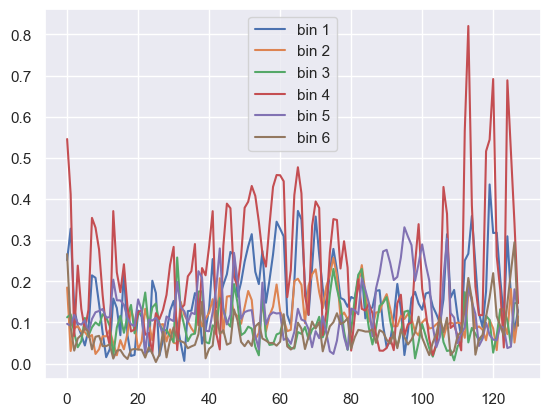

In [16]:
print(h2data[0].shape)


for b in range(NumBins):
    plt.plot(h2data[0][b,:], label = f'bin {b+1}')
plt.legend()
plt.show()

### plot some topos of data

In [17]:
# montage info 
montageIn = mne.channels.make_standard_montage("GSN-HydroCel-128")
info = mne.create_info(ch_names=montageIn.ch_names, sfreq=1, ch_types="eeg")
info.set_montage(montageIn)
print(montageIn)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 128 channels>


In [18]:
def init_TopoTemplate(title_In):
    """Prep topo plot fig and axes"""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4)) # ,gridspec_kw=dict(height_ratios=[3]), layout = 'constrained'
    axes[0].axis('off')
    axes[1].axis('off')
    axes[0].gridspec_kw=dict(height_ratios=[3])
    axes[1].gridspec_kw=dict(height_ratios=[3])
    plt.tight_layout()
    plt.suptitle(f'{title_In}', fontsize = 20)
    #axes[0].set_title(f'{title_In}', fontsize = 20)
    #axes[1].set_title(f'{title_In}', fontsize = 20)
    return fig, axes

In [19]:
NumBins = 6
NumChans = 128
contrast_levels=np.array([1, 3, 5, 16, 40, 100])
contrast_levels_labs=['1%', '3%', '5%', '16%', '40%', '100%']
cll=['1%', '3%', '5%', '16%', '40%', '100%']
ttl = ['2f1','4f1','6f1','8f1','2f2','4f2','6f2','8f2']
elec_Arc1_outer = [68,64,58,51,47,42,37,31,    80,87,93,98,97,96,95,94]
elec_Arc2 = [73,69,65,59,52,53,54,  55,  79,86,92,91,90,89,88]
elec_Arc3 = [74,70,66,60,61,  78,85,84,83,82,  81]
elec_Arc4_inner = [71,67,62,77,76,75,     72]
AllAnalysisChans = np.concatenate([elec_Arc1_outer,elec_Arc2,elec_Arc3,elec_Arc4_inner])
#AllAnalysisChans = np.concatenate([elec_Arc2,elec_Arc3,elec_Arc4_inner])
AnalysisChans = np.unique(AllAnalysisChans) - 1
VisChans = np.sort(AnalysisChans)
print(f'Channels to be visualized: {VisChans}')
ch_list = np.arange(0,NumChans,1)
ocm = np.zeros_like((ch_list))
ocm[VisChans] = True # set good chans to true
ocm_chans = ocm.astype(bool)

Channels to be visualized: [30 36 41 46 50 51 52 53 54 57 58 59 60 61 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97]


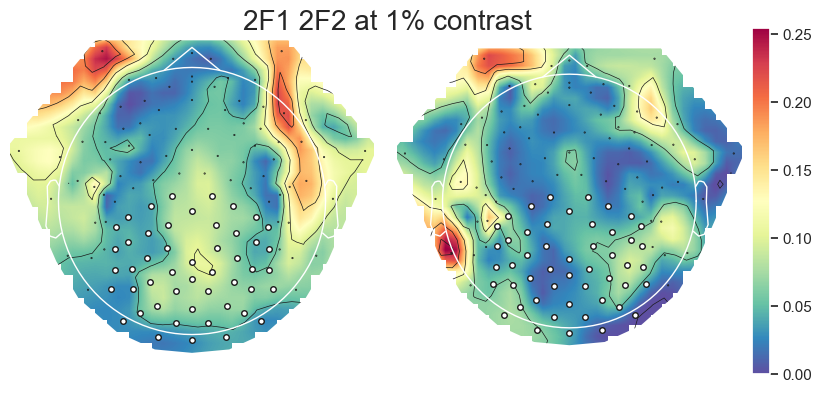

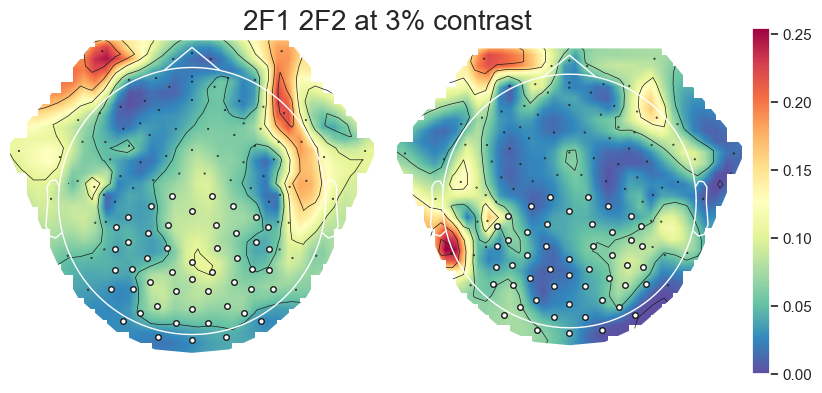

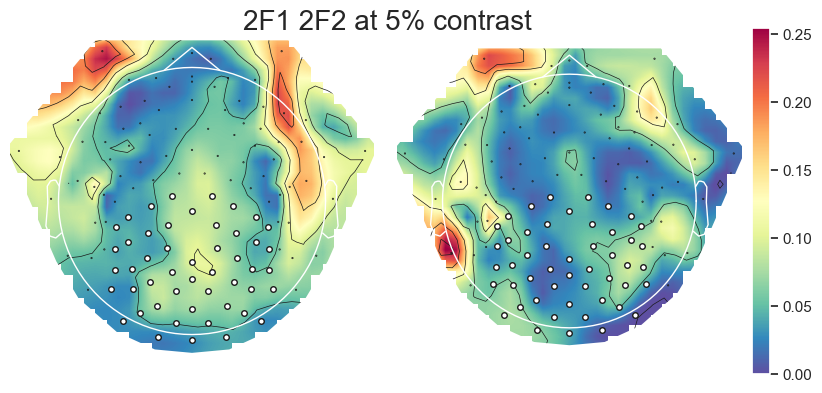

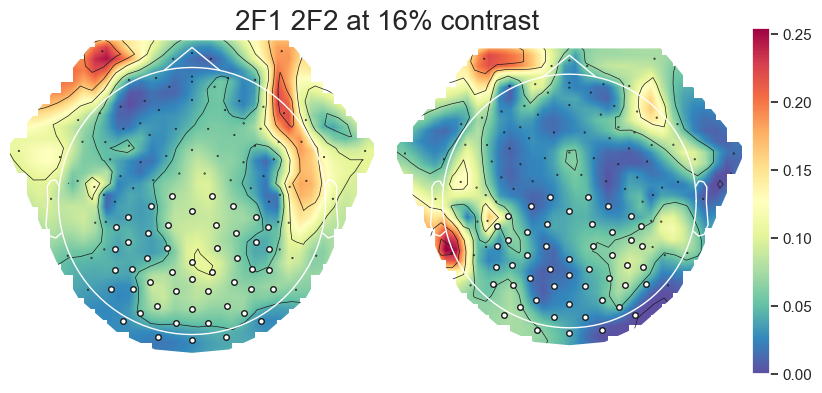

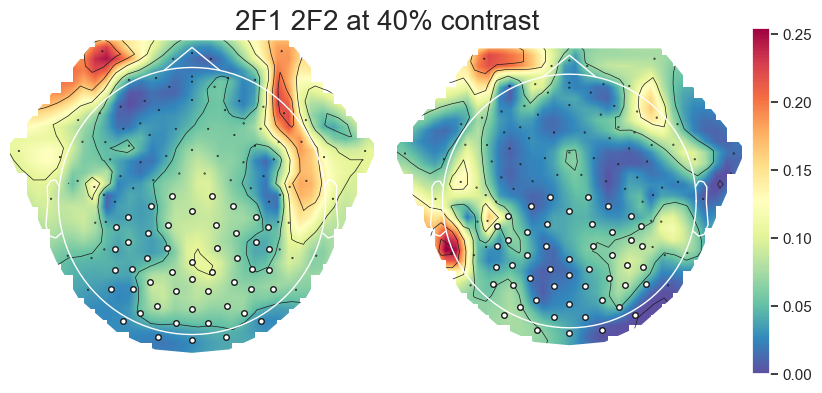

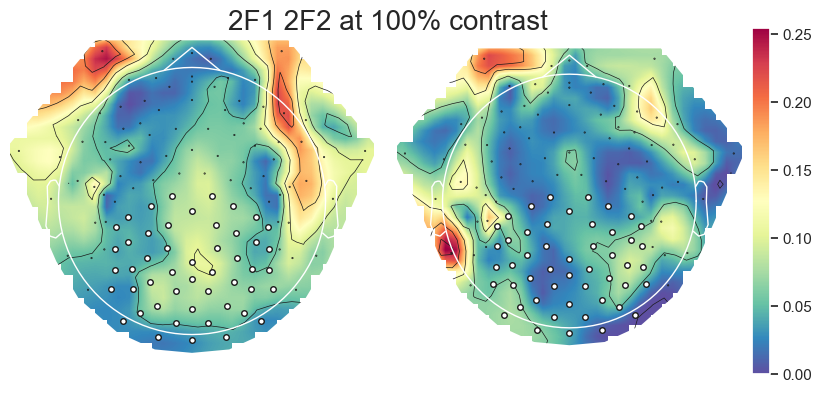

In [20]:

for bin in range(NumBins):
    tIn_F1 = h2data[0][b,:]
    tIn_F2 = h2data[1][b,:]
    fig, axes = init_TopoTemplate(f'2F1 2F2 at {cll[bin]} contrast')
    # left side plot
    im,_ = plot_topomap(tIn_F1, info,mask = ocm, axes = axes[0], show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    # middle  plot
    im,_ = plot_topomap(tIn_F2, info,mask = ocm, axes = axes[1],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')

    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax)


In [21]:
bi = np.tile(BinInd,8)
print(bi.shape)


(56,)


In [22]:
dataPerBin = {}
for i in range(len(NumBins)):
    if i > 0:
        bin_arr = np.zeros_like((bi))
        bin_arr[bi == i] = 1 # changr bool ind to get bin specific data
        dataPerBin[i-1] = DataOut[bi == 1,:,:]

TypeError: object of type 'int' has no len()

In [ ]:
print(dataPerBin[0].shape)

In [ ]:
colDim = np.shape(dataPerBin[0])[0]
print(colDim)
if colDim != (8):
    temp_dataPerBin = {} # write over original data in temp

    print(f'1F1 data is included, now removing this data...')

    for i in range(int(len(NumBins))-1):
        dOut = dataPerBin[i][1:,:,:]
        print(f'Data out dims: {dOut.shape}')
        temp_dataPerBin[i] = dOut
        print(f'All Done! :)')
    print(f'Data shapes are now good!')
    
    dataPerBin = temp_dataPerBin # rewrite over old data

else:
    print(f'Data is correct dims!')

In [ ]:
print(dataPerBin[0].shape)